# Tutorial 2 - Dynap-SE simulation & training

In [90]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from arcana.model import DPINeuron
from arcana.surrogate import fast_sigmoid, FastSigmoid

In [91]:
np.random.seed(0)
torch.manual_seed(0)

time = 2000

overlap_input = 0
class1_size = 25
class2_size = 25
input_size = 50
hidden_size = 50
output_size = 50

device = "cuda" if torch.cuda.is_available() else "cpu"

In [92]:
lr = 3e-2

active_label = 30 #Hz
inactive_label = 10#Hz
positive_freq = 20.0 #Hz
negative_freq = 1.0 #Hz
input_random_shuffle = np.argsort(np.random.rand(input_size))

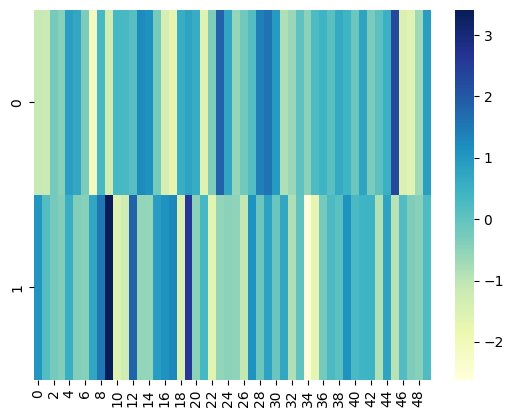

In [93]:
teaching_weight = torch.empty(2, hidden_size)
torch.nn.init.normal_(teaching_weight, mean=0.0, std=1.0)
teaching_weight_hidden = teaching_weight.to(device)
plt.figure()
ax = sns.heatmap(teaching_weight_hidden.cpu(), cmap="YlGnBu")
plt.show()

# teaching_weight_1 = torch.cat((torch.ones(1, hidden_size//2, device=device), -torch.ones(1, hidden_size//2)), dim=1)
# teaching_weight_2 = torch.cat((-torch.ones(1, hidden_size//2, device=device), torch.ones(1, hidden_size//2)), dim=1)
# teaching_weight = torch.cat((teaching_weight_1, teaching_weight_2), dim=0)
# teaching_weight_hidden = teaching_weight.to(device)
# plt.figure()
# ax = sns.heatmap(teaching_weight_hidden.cpu(), cmap="YlGnBu")
# plt.show()

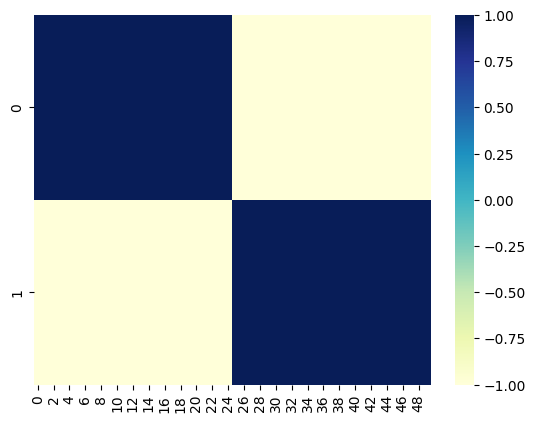

In [94]:
teaching_weight_1 = torch.cat((torch.ones(1, output_size//2, device=device), -torch.ones(1, output_size//2)), dim=1)
teaching_weight_2 = torch.cat((-torch.ones(1, output_size//2, device=device), torch.ones(1, output_size//2)), dim=1)
teaching_weight = torch.cat((teaching_weight_1, teaching_weight_2), dim=0)
teaching_weight_output = teaching_weight.to(device)
plt.figure()
ax = sns.heatmap(teaching_weight_output.cpu(), cmap="YlGnBu")
plt.show()

## Simulation loop

In [95]:
def runSim(neuron, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2):
    for t in range(input.shape[1]):
        out, state, = neuron(input[:,t,:], state)
        output.append(out[0])
        hidden.append(state[2][0])

        pre_trace1 = alpha1 * pre_trace1 + input[:,t,:]
        pre_trace2 = alpha2 * pre_trace2 + state[2]

        # Teaching
        signal = (torch.rand(1,2, device=device) < label*1e-3).float()
        teaching.append(signal[0])

        # First layer
        error = torch.einsum('bi,bj->ij', pre_trace1, FastSigmoid.pseudo_derivative(state[0][0]-neuron.layer1.Ith))
        gradient = torch.einsum('bj,ij->ji', signal@teaching_weight_hidden, error)
        neuron.layer1.W_ampa.data = neuron.layer1.W_ampa.data + lr*gradient
        
        # Second layer
        error = torch.einsum('bi,bj->ij', pre_trace2, FastSigmoid.pseudo_derivative(state[1][0]-neuron.layer2.Ith))
        gradient = torch.einsum('bj,ij->ji', signal@teaching_weight_output, error)
        neuron.layer2.W_ampa.data = neuron.layer2.W_ampa.data + lr*gradient

        with torch.no_grad():
            neuron.layer1.W_ampa.data = torch.clamp(neuron.layer1.W_ampa.data, 0.0, 1.0)
            neuron.layer1.W_ampa.data = torch.where(connection1, neuron.layer1.W_ampa.data, torch.zeros_like(neuron.layer1.W_ampa.data))

            neuron.layer2.W_ampa.data = torch.clamp(neuron.layer2.W_ampa.data, 0.0, 1.0)
            neuron.layer2.W_ampa.data = torch.where(connection2, neuron.layer2.W_ampa.data, torch.zeros_like(neuron.layer2.W_ampa.data))

    return state, pre_trace1, pre_trace2, hidden, output, teaching

## Torch model creation

In [96]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()

        self.layer1 = DPINeuron(
            input_size,
            hidden_size,
            Itau_mem=1.5e-12,
            Igain_mem=5e-12,#10e-12,
            Ith=0.012,
            Idc=0,
            refP=0.0,
            Ipfb_th=225e-12,
            Ipfb_norm=1.0e9,
            Itau_ampa=4e-12,
            Igain_ampa=5e-12,
            Iw_ampa=150e-12,
            dt=1e-3,
            train_Igain_mem=False,
            train_Itau_mem=False,
            train_ampa=True
        )

        self.layer2 = DPINeuron(
            hidden_size,
            output_size,
            Itau_mem=1.5e-12,
            Igain_mem=5e-12,#10e-12,
            Ith=0.012,
            Idc=0,
            refP=0.0,
            Ipfb_th=225e-12,
            Ipfb_norm=1.0e9,
            Itau_ampa=4e-12,
            Igain_ampa=5e-12,
            Iw_ampa=150e-12,
            dt=1e-3,
            train_Igain_mem=False,
            train_Itau_mem=False,
            train_ampa=True
        )

    def forward(self, input, state=None):
        if state is not None:
            (state1, state2, _) = state
        else:
            (state1, state2) = (None, None)

        output1, state1 = self.layer1(input, state1)
        output2, state2 = self.layer2(output1, state2)

        return output2, (state1, state2, output1)
    
model = Network(input_size, hidden_size, output_size)
model.to(device)
torch.nn.init.normal_(model.layer1.W_ampa, mean=0, std=0.75)
torch.nn.init.constant_(model.layer1.W_shunt, 0.0)
torch.nn.init.normal_(model.layer2.W_ampa, mean=0, std=0.75)
torch.nn.init.constant_(model.layer2.W_shunt, 0.0)

connection1 = torch.rand_like(model.layer1.W_ampa, device=device) < 0.25
connection2 = torch.rand_like(model.layer2.W_ampa, device=device) < 1.0

with torch.no_grad():
    model.layer1.W_ampa.data = torch.clamp(model.layer1.W_ampa.data, 0.0, 1.0)
    model.layer1.W_ampa.data = torch.where(connection1, model.layer1.W_ampa.data, torch.zeros_like(model.layer1.W_ampa.data))

    model.layer2.W_ampa.data = torch.clamp(model.layer2.W_ampa.data, 0.0, 1.0)
    model.layer2.W_ampa.data = torch.where(connection2, model.layer2.W_ampa.data, torch.zeros_like(model.layer2.W_ampa.data))

alpha1 = np.exp(-1e-3/model.layer1.tau_mem)
alpha2 = np.exp(-1e-3/model.layer1.tau_mem)

pre_trace1 = torch.zeros(1, input_size, device=device)
pre_trace2 = torch.zeros(1, hidden_size, device=device)

## Initial condition

In [97]:
input_1 = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([positive_freq]).repeat(1, time, class1_size), torch.tensor([negative_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
input_2 = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([negative_freq]).repeat(1, time, class1_size), torch.tensor([positive_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
input = torch.cat([input_1, input_2], dim=1)
input = input[:,:,input_random_shuffle].to(device)

In [98]:
output=[]
hidden=[]
teaching=[]
total_input=[]

total_input.append(input[0])

label=torch.tensor([[inactive_label, inactive_label]], device=device)
state = None
state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

## Training

### Label 1

In [99]:
input = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([positive_freq]).repeat(1, time, class1_size), torch.tensor([negative_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
input = input[:,:,input_random_shuffle].to(device)
total_input.append(input[0])

label=torch.tensor([[active_label, inactive_label]], device=device)
state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

### Label 2

In [100]:
input = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([negative_freq]).repeat(1, time, class1_size), torch.tensor([positive_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
input = input[:,:,input_random_shuffle].to(device)
total_input.append(input[0])

label=torch.tensor([[inactive_label, active_label]], device=device)
state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

### Train in loop

In [101]:
for _ in range(4):
    input = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([positive_freq]).repeat(1, time, class1_size), torch.tensor([negative_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
    input = input[:,:,input_random_shuffle].to(device)
    total_input.append(input[0])

    label=torch.tensor([[active_label, inactive_label]], device=device)
    state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

    input = (torch.rand(1, time, input_size) < torch.cat((torch.tensor([negative_freq]).repeat(1, time, class1_size), torch.tensor([positive_freq]).repeat(1, time, class2_size)), dim=2)*1e-3).float()
    input = input[:,:,input_random_shuffle].to(device)
    total_input.append(input[0])

    label=torch.tensor([[inactive_label, active_label]], device=device)
    state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

## Testing

In [102]:
input = (torch.rand(1, time*2, input_size) < torch.cat((torch.tensor([positive_freq]).repeat(1, time*2, class1_size), torch.tensor([negative_freq]).repeat(1, time*2, class2_size)), dim=2)*1e-3).float()
input = input[:,:,input_random_shuffle].to(device)
total_input.append(input[0])

label=torch.tensor([[inactive_label, inactive_label]], device=device)
state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

input = (torch.rand(1, time*2, input_size) < torch.cat((torch.tensor([negative_freq]).repeat(1, time*2, class1_size), torch.tensor([positive_freq]).repeat(1, time*2, class2_size)), dim=2)*1e-3).float()
input = input[:,:,input_random_shuffle].to(device)
total_input.append(input[0])

label=torch.tensor([[inactive_label, inactive_label]], device=device)
state, pre_trace1, pre_trace2, hidden, output, teaching = runSim(model, state, input, hidden, output, teaching, label, pre_trace1, pre_trace2, connection1, connection2)

In [103]:
output_stack = torch.stack(output, dim=0).detach().cpu().numpy()
hidden_stack = torch.stack(hidden, dim=0).detach().cpu().numpy()
teaching_stack = torch.stack(teaching, dim=0).detach().cpu().numpy()
total_input_stack = torch.cat(total_input, dim=0).detach().cpu().numpy()

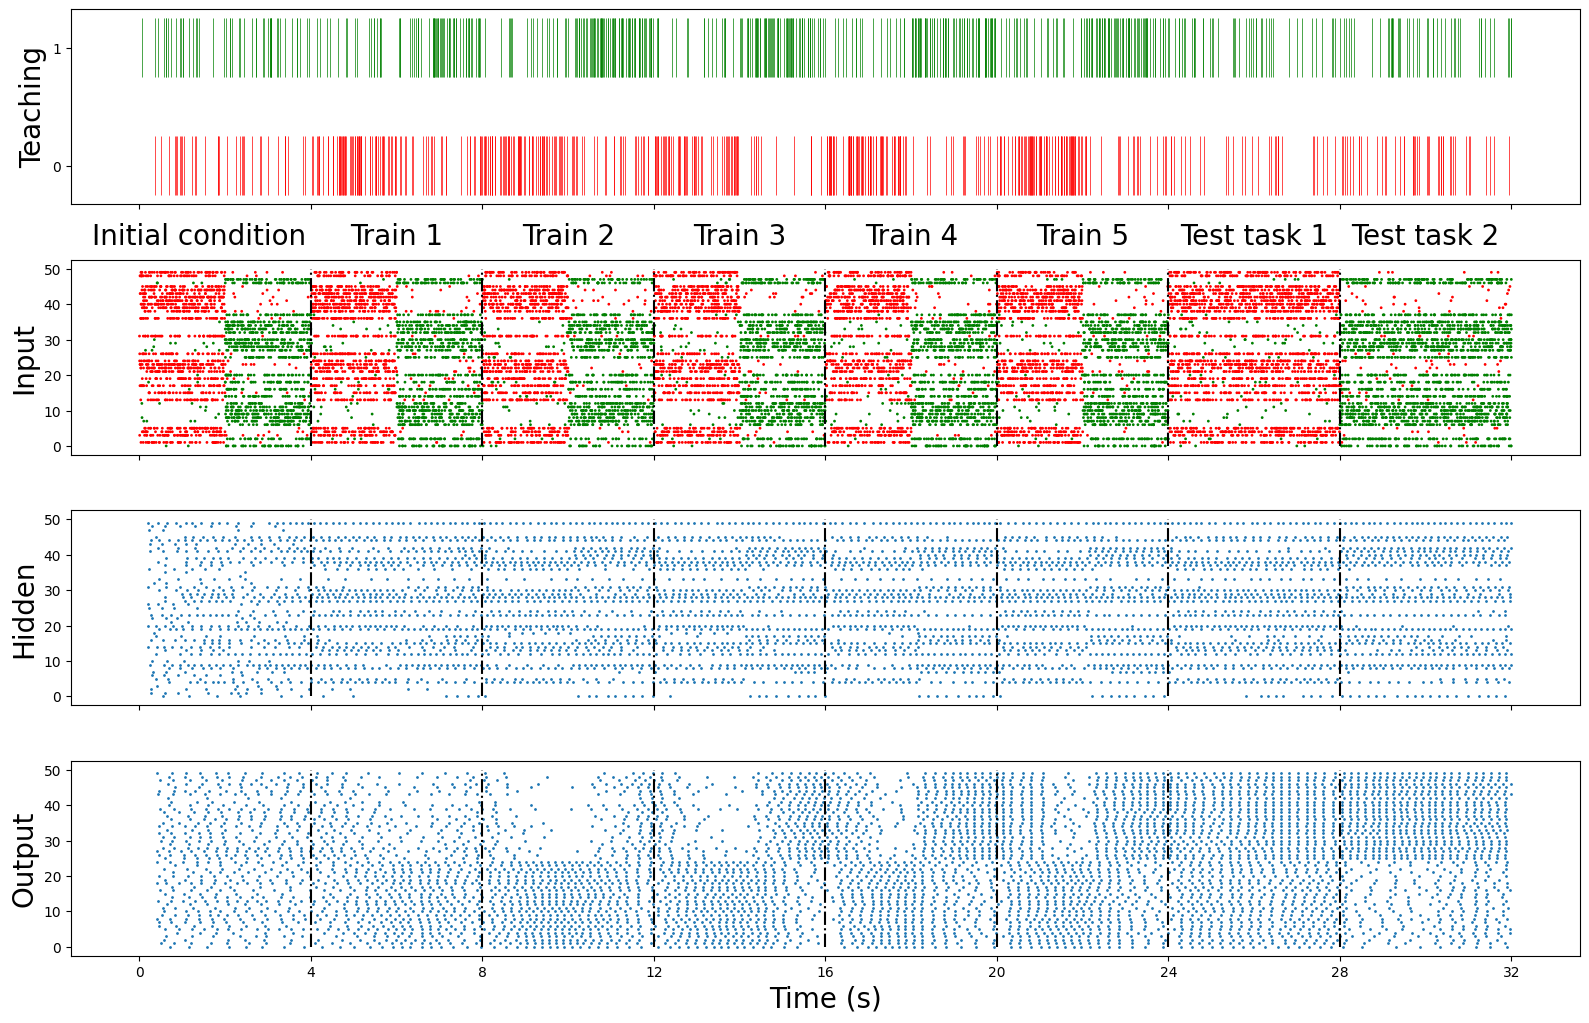

In [104]:
import pandas as pd

a = np.array(['r']*input_size)
a[input_size//2:] = 'g'
a = a[input_random_shuffle]

fig, axs = plt.subplots(4, 1, figsize=(16,10), sharex=True)
plt.rc('axes', labelsize=20)
axs[1].text(3.5*time/5000, input_size+7, "Initial condition", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(15*time/5000, input_size+7, "Train 1", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(25*time/5000, input_size+7, "Train 2", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(35*time/5000, input_size+7, "Train 3", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(45*time/5000, input_size+7, "Train 4", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(55*time/5000, input_size+7, "Train 5", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(65*time/5000, input_size+7, "Test task 1", horizontalalignment='center', fontsize=20, color='black')
axs[1].text(75*time/5000, input_size+7, "Test task 2", horizontalalignment='center', fontsize=20, color='black')

axs[0].set_ylabel('Teaching')
axs[1].set_ylabel('Input')
axs[2].set_ylabel('Hidden')
axs[3].set_ylabel('Output')

t = np.where(teaching_stack[:,0])[0]
axs[0].vlines(x=t/1000, ymin=-0.25, ymax=0.25, colors=['r'], linestyles='solid', linewidths=0.5) # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}
t = np.where(teaching_stack[:,1])[0]
axs[0].vlines(x=t/1000, ymin=0.75, ymax=1.25, colors=['g'], linestyles='solid', linewidths=0.5) # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}
axs[0].set_yticks([0,1])

# t, idx = np.where(teaching_stack)
# sns.histplot(pd.DataFrame({'x': t/1000, 'y': idx}), x='x', hue='y', kde=True, ax=axs[0])

t, idx = np.where(total_input_stack)
axs[1].scatter(t/1000,idx, s=1, c=a[idx])
axs[1].vlines(x=[10*time/5000, 20*time/5000, 30*time/5000, 40*time/5000, 50*time/5000, 60*time/5000, 70*time/5000], ymin=0, ymax=input_size, colors=['k', 'k', 'k', 'k'], linestyles='dashdot') # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}

t, idx = np.where(hidden_stack)
axs[2].scatter(t/1000,idx, s=1)
axs[2].vlines(x=[10*time/5000, 20*time/5000, 30*time/5000, 40*time/5000, 50*time/5000, 60*time/5000, 70*time/5000], ymin=0, ymax=hidden_size, colors=['k', 'k', 'k', 'k'], linestyles='dashdot') # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}

t, idx = np.where(output_stack)
axs[3].scatter(t/1000,idx, s=1)
axs[3].vlines(x=[10*time/5000, 20*time/5000, 30*time/5000, 40*time/5000, 50*time/5000, 60*time/5000, 70*time/5000], ymin=0, ymax=hidden_size, colors=['k', 'k', 'k', 'k'], linestyles='dashdot') # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}
axs[3].set_xticks([0,4,8,12,16,20,24,28,32])

fig.tight_layout()

plt.xlabel('Time (s)')
plt.show()

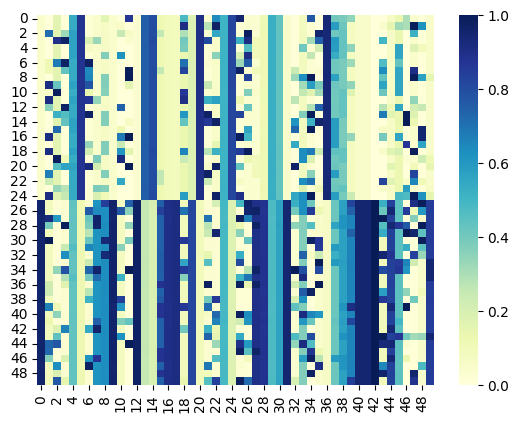

In [106]:
plt.figure()
ax = sns.heatmap(model.layer2.W_ampa.detach().cpu(), cmap="YlGnBu")
plt.show()